In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing

import gradient
import dataset
import computations
import layer
#from layer import Linear, Softmax, Gradient
import network

import datetime
import time

In [2]:
np.random.seed(400)
np.seterr(over='raise');
plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [3]:
network1 = network.Network()
cifar = dataset.CIFAR_IMAGES()
#asgn1.test_batch_images(cifar_batch1)

In [4]:
#### Exercise - 4 ###
# Read in the data & initialize the parameters of the network
# TRAIN = 45.000 - VALIDATION = 5.000  ... TEST = 10.000
filePathLocal_labels = 'Dataset/batches.meta'
#filePathLocal_data_TRAIN = 'Dataset/data_batch_1'
#filePathLocal_data_VALIDATION = 'Dataset/data_batch_2'
filePathLocal_data_ALL = ['Dataset/data_batch_1', 'Dataset/data_batch_2', 'Dataset/data_batch_3', 'Dataset/data_batch_4', 'Dataset/data_batch_5']
filePathLocal_data_TEST = 'Dataset/test_batch'

filePathList = (filePathLocal_data_ALL, filePathLocal_data_TEST)

# Read TRAIN, VALIDATION, TEST data into numpy arrays (numpy.ndarray) from local files
network1.ReadData_Exercise4(cifar, filePathList)
# X = (d, N), Y = (K, N), y = (N,)   # N=number of total images in X
# X = (3072, 10000), Y = (10, 10000), y = (10000,)

# Find the MEAN and STD of trainX and broadcast them for matrix calculations
# trainX_Broadcast_MeanStd = (mean_train_X_broadcast, std_train_X_broadcast)
#trainX_Broadcast_MeanStd = network1.MeanStd_Train_X(network1.train_X)

# MEL
# Transform the INPUT to have zero mean ** Check that one if we need to transfer all of them separately or
# only having the normalization as in here??
# Normalize all INPUT data by using MEAN and STD of TRAIN DATA
'''
train_X_Norm = network1.NormalizeData(network1.train_X, trainX_Broadcast_MeanStd)
validation_X_Norm = network1.NormalizeData(network1.validation_X, trainX_Broadcast_MeanStd)
test_X_Norm = network1.NormalizeData(network1.test_X, trainX_Broadcast_MeanStd)
'''

train_X_Norm = network1.NormalizeData_Broadcast(network1.train_X, network1.train_X)
#validation_X_Norm = network1.NormalizeData_Broadcast(network1.validation_X, network1.train_X)
validation_X_Norm = network1.NormalizeData_Per_DataSet(network1.validation_X)
#test_X_Norm = network1.NormalizeData_Broadcast(network1.test_X, network1.train_X)
test_X_Norm = network1.NormalizeData_Per_DataSet(network1.test_X)

# mu = 0; d = network1.train_X.shape[0]; m = 50; K = network1.train_Y.shape[0]
# we will use only 20 of 3072 to have a dimension reduction in comparing grad_analytic and grad_Numerical
#mu = 0; d = 20; m = 50; K = network1.train_Y.shape[0]
mu = 0; d = network1.train_X.shape[0]; m = 50; K = network1.train_Y.shape[0]

initial_sizes = (mu, d, m, K)

sigma1 = 1 / int(np.sqrt(d))
sigma2 = 1 / np.sqrt(m)

# Generate W1, W2, b1, b2 matrices with initial values
#(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
(W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)
# W1 = (50, 3072), W2 = (10, 50), b1 = (50, 1), b2 = (10, 1) # if we use the whole dimensions/features
# W1 = (50, 20), W2 = (10, 50), b1 = (50, 1), b2 = (10, 1) # if we use 20 dimensions/features
# W1 = (m, d), W2 = (K, m), b1 = (m, 1), b2 = (K, 1)

In [5]:
'''
print("Mean-STD:\n trainX_Broadcast_MeanStd[0]=\n{}\n\ntrainX_Broadcast_MeanStd[1]=\n{}".\
      format(trainX_Broadcast_MeanStd[0], trainX_Broadcast_MeanStd[1]))
print("\n\nMean-STD:\n train_X_Norm.mean(axis=1)={}\n\n".format(train_X_Norm.mean(axis=1)))
'''
print("Shape check:\n train_X_Norm={}\t validation_X_Norm={}\t test_X_Norm={}".format(train_X_Norm.shape, validation_X_Norm.shape, test_X_Norm.shape))
print(" train_Y={}\t\t validation_Y={}\t\t test_Y={}".format(network1.train_Y.shape, network1.validation_Y.shape, network1.test_Y.shape))
print(" train_y={}\t\t validation_y={}\t\t\t test_y={}".format(network1.train_y.shape, network1.validation_y.shape, network1.test_y.shape))
print(" W1={}\t\t\t W2={}\t\t\t\t b1={}\t\t\t b2={}".format(W1.shape, W2.shape, b1.shape, b2.shape))

Shape check:
 train_X_Norm=(3072, 45000)	 validation_X_Norm=(3072, 5000)	 test_X_Norm=(3072, 10000)
 train_Y=(10, 45000)		 validation_Y=(10, 5000)		 test_Y=(10, 10000)
 train_y=(45000,)		 validation_y=(5000,)			 test_y=(10000,)
 W1=(50, 3072)			 W2=(10, 50)				 b1=(50, 1)			 b2=(10, 1)


In [6]:
#def Plot_Train_Validation_Cost_Accurracy(self, Cost_Train, Cost_Validation, Acc_Train, Acc_Validation):
def Plot_Train_Validation_Cost_Accurracy(Cost_Train, Cost_Validation, Acc_Train, Acc_Validation, Eta):
        plt.subplot(1,3,1)
        plt.plot(Cost_Train, 'g-', label='Train')
        plt.plot(Cost_Validation, 'r-', label='Validation')
        plt.title('Cost Comparison')
        plt.xlabel('n_records')
        plt.ylabel('Cost')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,3,2)
        plt.plot(Acc_Train, 'g-', label='Train')
        plt.plot(Acc_Validation, 'r-', label='Validation')
        plt.title('Accuracy Comparison')
        plt.xlabel('n_records')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,3,3)
        plt.plot(Eta, 'g-', label='Eta')
        plt.title('Eta Change')
        plt.xlabel('Time')
        plt.ylabel('Eta')
        plt.legend()
        plt.grid('on')

In [7]:
def Coarse_Search(l_min, l_max):
    l = l_min + (l_max - l_min) * np.random.uniform(0,1)
    lambda_coarse = pow(10, l)
    return lambda_coarse

In [8]:
# this function uses the BATCH data with a SMOOTH_COST to calculate the ACCURACY & COST
def Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list):
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m,
    #                eta_min, eta_max]
    '''
    Up until now, we have trained our networks with Vanilla mini-batch gradient descent. 
    To help speed up training times and avoid time-consuming searches for good values of eta, we will now
    implement mini-batch-GD training where the learning rate at each update step is defined in a cylical way
    check equations (14) and (15) in the assignment.
    '''
    network1 = param_list[0]
    train_X_Norm = param_list[1]      # 45.000 images
    validation_X_Norm = param_list[2] # 5.000 images
    # the size of a mini-batch. in other words, number of images in 1 mini-batch
    batch_size = param_list[3]        # 100
    # number of triangles that you want to use to test different eta values
    n_cycles = param_list[4]         # 1
    # regularization coefficient (punishment)
    lambda_cost = param_list[5]      # 0.01
    # how many calculations do you want to see per cycle? = 10? 20? 30? to plot the graph
    # record_per_cycle = 100  (+1 is to show the first calculation, as well)
    record_per_cycle = param_list[6]
 
    d = train_X_Norm.shape[0]       # dimension of X_train... 3072 = 32 x 32 x 3
    m = param_list[7]               # number of nodes in the hidden layer... 50
    K = network1.train_Y.shape[0]  # number of classes... 10
    eta_min = param_list[8] # learning rate (step-size)   i.e. 1e-5 
    eta_max = param_list[9] # learning rate (step-size)   i.e. 1e-1  

    # Generate W1, W2, b1, b2 matrices with initial values
    sigma1 = 1 / int(np.sqrt(d))   # std to initialize W1
    sigma2 = 1 / np.sqrt(m)        # std to initialize W2
    #(W1, W2, b1, b2) = network1.Initialize_W_b([mu, d, m, K], sigma1, sigma2)
    initial_sizes = [0, d, m, K]
    (W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)

    W = [W1, W2]
    b = [b1, b2]

    linearLayer1 = layer.Linear()
    reluLayer = layer.ReLU()             # not an exact layer but operational step..
    linearLayer2 = layer.Linear()
    softmaxLayer = layer.Softmax()       # not an exact layer but operational step..
    ReLUlayer = layer.ReLU()
    grad = gradient.Gradient()

    layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]
    # total_batch = how many mini-batches will we need to cover the entire training set
    # we will use 45000 images for training = train_X_Norm.shape[1]
    # total_batch = 45000/100 = 450
    #total_batch = int(np.ceil(train_X_Norm.shape[1] / batch_size))
    total_batch = int(np.floor(train_X_Norm.shape[1] / batch_size))
    
    # A full cycle: once goes up (from eta_min to eta_max) and once goes down (from eta_max to eta_min)
    # so we multiply by 2    
    n_steps = 2 * total_batch  # 2 * 450 = 900      # this was given by definition in the assignment
    # n_steps / total_batch = 2 is picked (before, this value was used as k in exercise-3)
    # but in exercise-3, we were given the n_steps, now, n_steps is calculated by the above equation and 
    # k is given as 2 according to the equation
    ##### n_epochs = int(2 * n_cycles * (n_steps / total_batch))
    # k=2 is accepted as in this formula n_s = k[n/n_batch] ... 1 cycle= 2 * n_s
    # n_epochs = 2 * k * n_cycles = 2 * 2 * 1 = 4 in the first example
    n_epochs = 2 * 2 * n_cycles
    
    # !!!! CAUTION !!!! the usage of n_records and t is different than the previous functions - Do not confuse!
    n_records = total_batch * n_epochs   # number of batches will be used IN TOTAL for ALL calculations
    # i.e. 450 * 4 = 1800 
    
    # how many points in total we will have in the COST graph
    cost_record = record_per_cycle * n_cycles + 1  # 100 * 1 + 1 = 101
    ###comparison_number = total_batch/cost_record  
    # to be able to have that many points, at which batch we should run the COST functions (e.g. in every 18 batch)
    comparison_number = int(n_records / (cost_record - 1))  # 1800/100 = 18
    
    eta_train = np.zeros(n_records)              # we will check if we properly make a triangle
    
    J_epocs_train = np.zeros(cost_record)        # cost array to plot and see how cost changes
    Accuracy_epocs_train = np.zeros(cost_record) # accuracy array
    J_epocs_validation = np.zeros(cost_record) 
    Accuracy_epocs_validation = np.zeros(cost_record) 
    
    #print('batch_size: {}, lambda_cost : {}, d: {}, m: {}, K: {}'.format(batch_size, lambda_cost, d, m, K))
    ##print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}, cost_record: {}'.format(total_batch, n_steps, n_epochs, n_records, cost_record))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}'.format(total_batch, n_steps, n_epochs, 
    #                                                                            n_records))
    #print('\nrecord_per_cycle: {}, cost_record : {}, comparison_number: {}'.format(record_per_cycle, cost_record, 
     #                                                                              comparison_number))
  
    # cycleID in use.. if n_cycles=0 then cycle max will be 0. else it will be incremented by 1 at each 2*n_steps
    cycle_no = 0
    J_train_sum = 0
    n_records = 0       # this will basically show the number of batches processed until now
    list_params = []
    smooth_cost = 0
    cost_record = 0
    # step number in the current cycle, it resets with a new cycle. 
    cycle_step = 0   # just to see where we are in the current triangle
    
    start_time = datetime.datetime.now()
    for e in range(n_epochs):
        for batch in range(total_batch):
            index_list = list(range(batch * batch_size, (batch + 1) * batch_size))
            # shuffling is not necessary but good to have
            np.random.shuffle(index_list)
            X_batch = train_X_Norm[:, index_list]
            Y_batch = network1.train_Y[:, index_list]

            P, H = network1.EvaluationClassifier(layers, X_batch, W, b)

            G2 = -np.subtract(Y_batch, P)  # 
            N2 = Y_batch.shape[1]          # 

            (grad_W2, grad_b2, G1) = grad.ComputeGradients_Linear_HiddenLayer(N2, G2, H, lambda_cost, W2) 
            G0 = reluLayer.Backward(G1, H)
            N1 = H.shape[1]                # 

            (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N1, G0, X_batch, lambda_cost, W1)
            
            # n_cycles = 1   # corresponds to "L array" in 2.L.ns in the assignment .. 
            # L=the current cycle number ... n_cycles=the total number of cycles to be applied
            # so L is an element of n_cycle >> i.e. L = {0, 1, 2, 3} if n_cycles = 4 
            #if 2*cycle_no*n_steps <= t and t <= (2*cycle_no+1)*n_steps:
            # n_records corresponds to t in the formula
            if 2*cycle_no*n_steps <= n_records and n_records <= (2*cycle_no+1)*n_steps:
                #eta = eta_min + (t - 2*cycle_no*n_steps)/n_steps*(eta_max-eta_min)
                eta = eta_min + (n_records - 2*cycle_no*n_steps)/n_steps*(eta_max-eta_min)
            #elif (2*cycle_no+1)*n_steps <= t and t <= 2*(cycle_no+1)*n_steps:
            elif (2*cycle_no+1)*n_steps <= n_records and n_records <= 2*(cycle_no+1)*n_steps:
                #eta = eta_max - (t - (2*cycle_no+1)*n_steps)/n_steps*(eta_max-eta_min)
                eta = eta_max - (n_records - (2*cycle_no+1)*n_steps)/n_steps*(eta_max-eta_min)
            
            eta_train[n_records] = eta
            
            # W1star, W2star
            W1 = W1 - eta * grad_W1
            W2 = W2 - eta * grad_W2

            # b1star, b2star
            bstar_m1 = b1 - eta * grad_b1
            b1 = bstar_m1[:, :1]  # there's a broadcast issue needs to be fixed, that's why we pick only 1 column

            bstar_m2 = b2 - eta * grad_b2
            b2 = bstar_m2[:, :1]  # broadcast issue, this is a quick workaround - use 1 column
            
            W = [W1, W2]
            b = [b1, b2]

            #if n_records % 10 == 0:
            if n_records == 0 or (n_records + 1) % comparison_number == 0:
                #print('\nepoch: {}, batch: {}, n_records: {}, cycle_step: {}'.format(e, batch, n_records, cycle_step))

                J_train = network1.Cost(X_batch, Y_batch, W, b, lambda_cost)
                J_train_sum += J_train
                smooth_cost = J_train_sum/(cost_record + 1)
                #J_epocs_train[n_records] = J_train
                J_epocs_train[cost_record] = smooth_cost

                ## If we use the ALL TRAINING data to calculate the training accuracy:
                # it feels like better to use that one
                P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
                k_train = np.argmax(P, axis=0)
                A_train = network1.ComputeAccuracy(k_train, network1.train_y)
                Accuracy_epocs_train[cost_record] = A_train

                J_validation = network1.Cost(validation_X_Norm , network1.validation_Y, W, b, lambda_cost)
                J_epocs_validation[cost_record] = J_validation

                P_val, H_val = network1.EvaluationClassifier(layers, validation_X_Norm, W, b)
                k_validation = np.argmax(P_val, axis=0)
                A_validation = network1.ComputeAccuracy(k_validation, network1.validation_y)
                Accuracy_epocs_validation[cost_record] = A_validation
                
                cost_record += 1
                
                #print('cycle_no: {} ... eta: {} ... time: {}'.format(cycle_no, eta, datetime.datetime.now()))
                #print('J_train: {} ... smooth_cost : {} ... J_validation: {}'.format(J_train, smooth_cost, J_validation))
                #print('\neta: {}, cycle_step: {}'.format(eta, cycle_step))
            
            #if n_records == 0 or (n_records+1) % 100 == 0:
             #   print('\ncycle_no: {}, epoch: {}, batch: {}, n_records: {}, cycle_step: {}'.format(cycle_no, e, batch, n_records, cycle_step))                
                           
            n_records += 1
            cycle_step += 1
            
            #if t % (2 * n_steps) == 0:
            if n_records % (2 * n_steps) == 0:
                cycle_no += 1
                cycle_step = 0

    end_time = datetime.datetime.now()
    
    #print("Calculation time of Train_Cyclical: " + str(end_time - start_time))
    #print("x-axis (steps) must be multiplied by 10 since the values recorded once in every 10 Cycle")
    
    Plot_Train_Validation_Cost_Accurracy(J_epocs_train, J_epocs_validation, Accuracy_epocs_train, 
                                         Accuracy_epocs_validation, eta_train)
    #print('batch_size: {}, lambda_cost : {}, d: {}, m: {}, K: {}'.format(batch_size, lambda_cost, d, m, K))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}, cost_record: {}'.format(total_batch, n_steps, n_epochs, n_records, cost_record))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}'.format(total_batch, n_steps, 
     #                                                                           n_epochs, n_records))
    #print('\nrecord_per_cycle: {}, cost_record : {}, comparison_number: {}'.format(record_per_cycle, 
     #                                                                              cost_record, comparison_number))
    return layers, W, b, eta_train

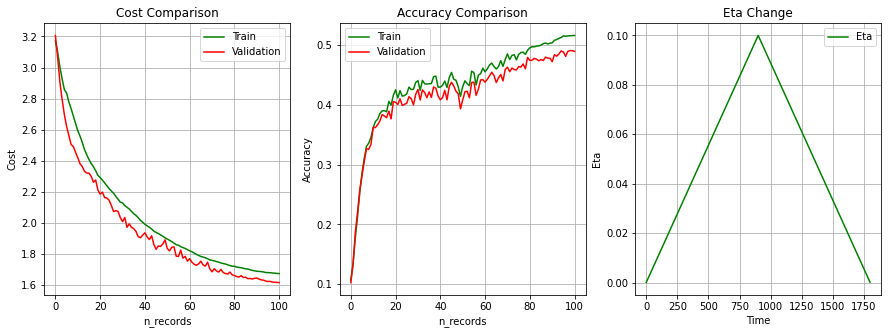

In [9]:
# In this function, we didn't calculate the cost for each batch but we calculated it for 100 batches out of 1800 
# in 1 cycle and this helped us to save a lot of time with a similar result with the one I calculated J for 
# each batch
# takes ONLY around 40 seconds!
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, 0.01, 100, 50, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)


In [10]:
print('Eta_Train\nmin: {}\tmax: {}\tmean: {}\tmedian: {}\nstd: {}\tvar: {}'.format(min(eta_train), 
        max(eta_train), np.mean(eta_train), np.median(eta_train), np.std(eta_train), np.var(eta_train)))

Eta_Train
min: 1e-05	max: 0.1	mean: 0.050005	median: 0.05000500000000001
std: 0.028864662343454958	var: 0.0008331687322016667


In [11]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4924


/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

Calculation time of lambda_coarse: 0:05:25.496845


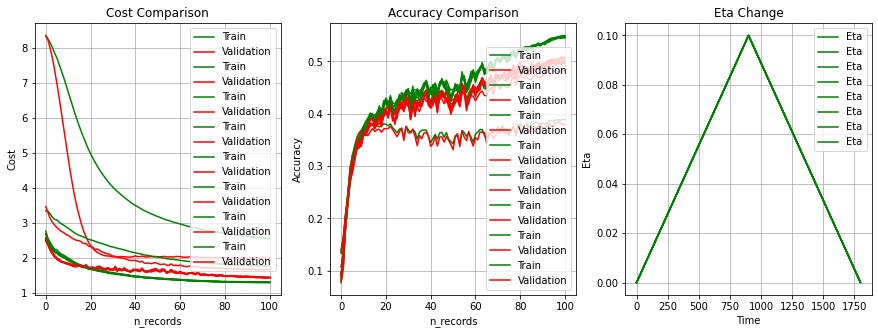

In [12]:
# takes around 5.5 minutes!! >> LIMIT the J (Cost) calculation per cycle instead
# of calculating J per batch
# this one uses the formula given in the assignment for the lambda_coarse values
lambda_coarse_list = []
#n_cycles = 1
#record_per_cycle = 100
start_time = datetime.datetime.now()
for i in range(8):
    lambda_coarse = Coarse_Search(-5, -1)
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m,
    #               eta_min, eta_max]
    param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, lambda_coarse, 100, 50, 1e-5, 1e-1]
    layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

    P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
    k_test = np.argmax(P_test, axis=0)
    A_test = network1.ComputeAccuracy(k_test, network1.test_y)
    #lambda_coarse_list.append([lambda_coarse, A_test, W, b])
    lambda_coarse_list.append([lambda_coarse, A_test])
    #print(datetime.datetime.now())
    #print('Test accuracy of {}. lambda ({})={}'.format(i, lambda_coarse, A_test))
    
end_time = datetime.datetime.now()
print("Calculation time of lambda_coarse: " + str(end_time - start_time))

In [13]:
# [lambda, test_accuracy]
lambda_coarse_list

[[3.4654364956587273e-05, 0.4963],
 [0.09769685956289327, 0.3884],
 [0.0001955309850790619, 0.5001],
 [9.526945539447682e-05, 0.5024],
 [3.3350075921078503e-05, 0.5017],
 [0.014539373481118277, 0.487],
 [0.00017842001970348124, 0.4965],
 [6.973282303589172e-05, 0.4973]]

In [14]:
import fileinput

def Time_Stamp():
    date_time = datetime.datetime.now()
    
    D = str(date_time.day)
    M = str(date_time.month)
    Y = str(date_time.year)

    h = str(date_time.hour)
    m = str(date_time.minute)
    s = str(date_time.second)
    
    date_array = [D, M, Y, h, m, s]
    
    return date_array
    
def FileNameUnique(prefix = "Lambda_"):
    file_name = prefix

    date_array = Time_Stamp()
    
    for idx, i in enumerate(date_array):
        if idx == 2:
            file_name += i + '_'
        elif idx == 5:
            file_name += i + '.txt'
        else:
            file_name += i + '.'

    #print(file_name)
    return file_name
                
def Save_Lambda_TestAccuracy(lambda_coarse_list):
    file_name = FileNameUnique()
 
    with open(file_name, "w") as output:
            for lambda_c in lambda_coarse_list:
                lambda_c_save = str(lambda_c[0]) + "," + str(lambda_c[1])
                #output.write(str(movie) + "\n")
                output.write(lambda_c_save + "\n")

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

Calculation time of lambda_coarse: 0:10:57.812096


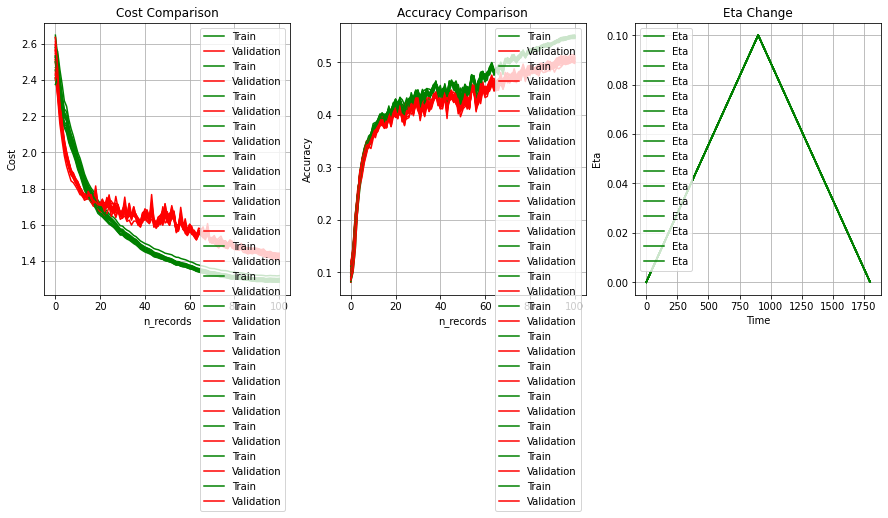

In [15]:
# Search of LAMBDA for a narrower range
# takes around 12 minutes
# HERE we NARROWED the range >> (-5, -1) to (-5, -4) and used 16 samples instead of 8
lambda_coarse_list = []
start_time = datetime.datetime.now()
for i in range(16):
    lambda_coarse = Coarse_Search(-5, -4)
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m,
    #               eta_min, eta_max]
    param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, lambda_coarse, 100, 50, 1e-5, 1e-1]
    layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)
    
    P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
    k_test = np.argmax(P_test, axis=0)
    A_test = network1.ComputeAccuracy(k_test, network1.test_y)
    #lambda_coarse_list.append([lambda_coarse, A_test, W, b])
    lambda_coarse_list.append([lambda_coarse, A_test])
    #print(datetime.datetime.now())
    #print('Test accuracy of {}. lambda ({})={}'.format(i, lambda_coarse, A_test))
    
Save_Lambda_TestAccuracy(lambda_coarse_list)
end_time = datetime.datetime.now()
print("Calculation time of lambda_coarse: " + str(end_time - start_time))

In [16]:
lambda_coarse_list

[[2.3623509445618744e-05, 0.4978],
 [4.412783084739363e-05, 0.4983],
 [4.560435734959645e-05, 0.5021],
 [1.1262450346489812e-05, 0.5007],
 [9.818671394260568e-05, 0.4966],
 [1.5749133438880033e-05, 0.4995],
 [1.3164243736202251e-05, 0.5054],
 [6.0485879260023e-05, 0.4998],
 [9.068077588056084e-05, 0.5012],
 [6.869406073885309e-05, 0.4931],
 [2.1980450649925166e-05, 0.5011],
 [2.6665029322969088e-05, 0.4987],
 [2.760969250853863e-05, 0.5011],
 [2.32252187405257e-05, 0.501],
 [1.0561798881093307e-05, 0.4993],
 [4.359936046517301e-05, 0.4988]]

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

Calculation time of lambda_coarse: 0:10:48.951884


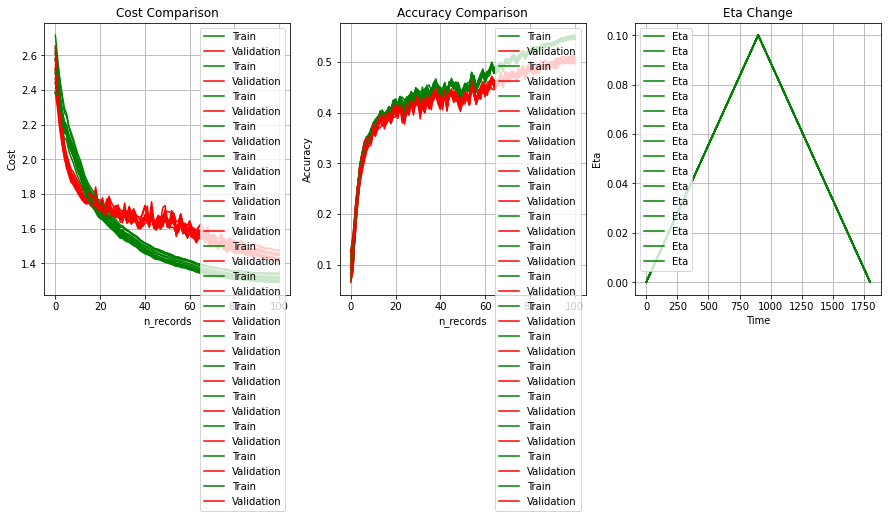

In [17]:
# Search of LAMBDA for a narrower range
# takes around 12 minutes
# HERE we NARROWED the range >> (-5, -1) to (-5, -4) and used 16 samples instead of 8
lambda_coarse_list = []
start_time = datetime.datetime.now()
for i in range(16):
    lambda_coarse = Coarse_Search(-5, -3)
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m,
    #               eta_min, eta_max]
    param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, lambda_coarse, 100, 50, 1e-5, 1e-1]
    layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)
    
    P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
    k_test = np.argmax(P_test, axis=0)
    A_test = network1.ComputeAccuracy(k_test, network1.test_y)
    #lambda_coarse_list.append([lambda_coarse, A_test, W, b])
    lambda_coarse_list.append([lambda_coarse, A_test])
    #print(datetime.datetime.now())
    #print('Test accuracy of {}. lambda ({})={}'.format(i, lambda_coarse, A_test))
    
Save_Lambda_TestAccuracy(lambda_coarse_list)
end_time = datetime.datetime.now()
print("Calculation time of lambda_coarse: " + str(end_time - start_time))

In [18]:
lambda_coarse_list

[[0.00032933566659033414, 0.4969],
 [0.0008484962871457188, 0.5018],
 [1.7499162934356765e-05, 0.502],
 [1.608819021269823e-05, 0.4984],
 [5.1366343447880185e-05, 0.5017],
 [0.0003867206597413132, 0.4976],
 [0.0006962310857509251, 0.4987],
 [0.0002612298487195736, 0.4954],
 [6.503713689980735e-05, 0.4973],
 [0.0004215372047767062, 0.4988],
 [1.8161231262606217e-05, 0.4991],
 [0.0003026456374925449, 0.4989],
 [5.260979986414023e-05, 0.4971],
 [0.00046666178523047065, 0.4978],
 [1.500921867517104e-05, 0.5009],
 [0.00010091058853135455, 0.495]]

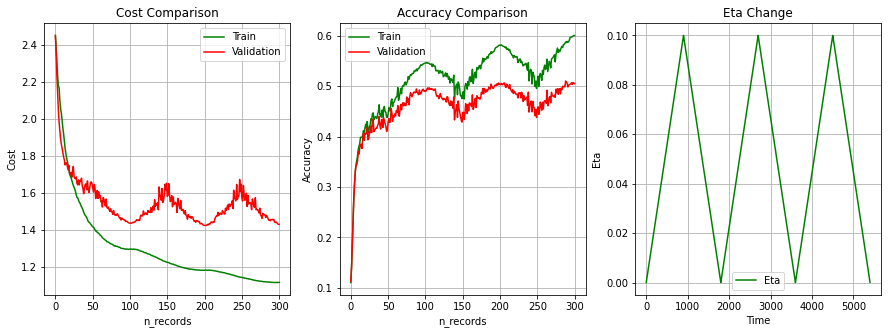

In [19]:
# In this functions, I didn't calculate the cost for each batch but I calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes ONLY 2 minutes 12 seconds!
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, lambda_coarse, 100, 50, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)


In [20]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.5004


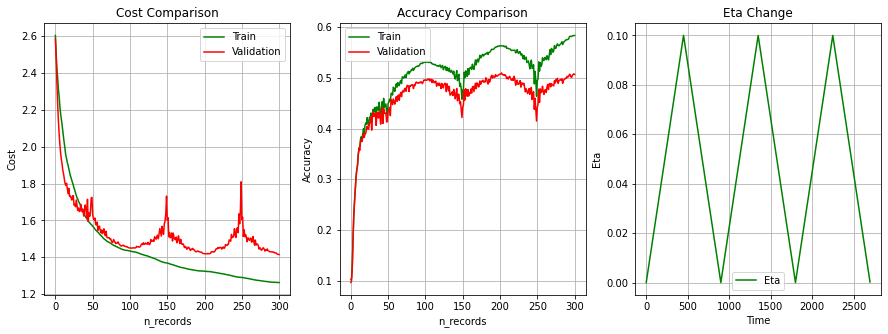

In [21]:
# In this functions, we didn't calculate the cost for each batch but 
# we calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes 2 minutes 3 seconds!
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 200, 3, lambda_coarse, 100, 50, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

In [22]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.5092


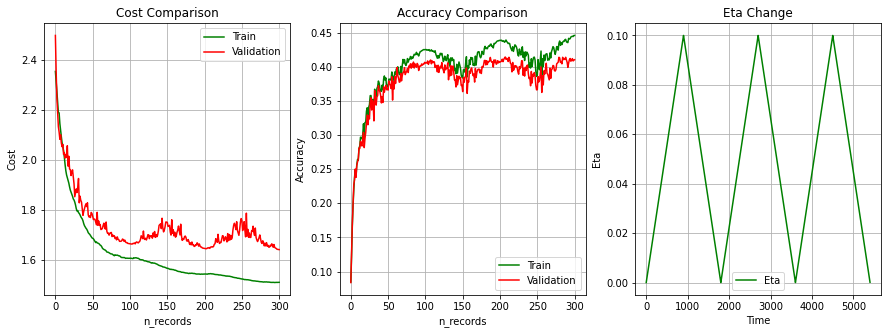

In [23]:
# In this function, we didn't calculate the cost for each batch but 
# we calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes 1 minute 34 seconds!  >> HERE we DECREASED the number of HIDDEN NODES from 50 to 10
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, lambda_coarse, 100, 10, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

In [24]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4122


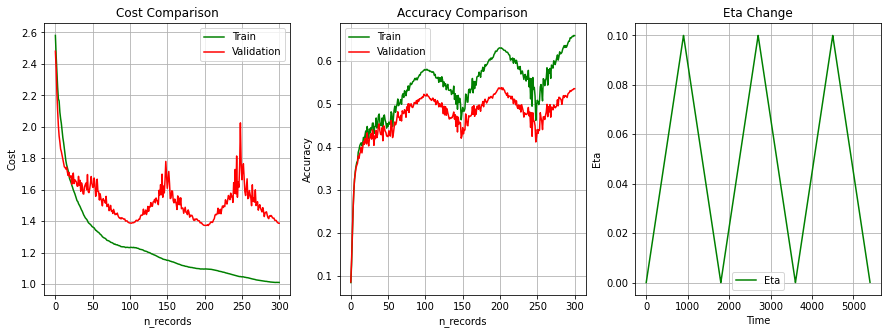

In [25]:
# In this function, we didn't calculate the cost for each batch but 
# we calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes arund 3 minutes! >> HERE we INCREASED the number of HIDDEN NODES from 50 to 100
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, lambda_coarse, 100, 100, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

In [26]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.5201


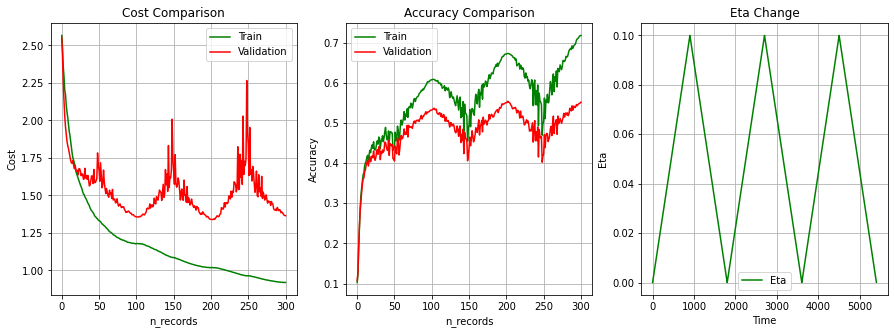

In [27]:
# In this function, we didn't calculate the cost for each batch but 
# we calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes arund 3 minutes! >> HERE we INCREASED the number of HIDDEN NODES from 50 to 100
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, lambda_coarse, 100, 200, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

In [28]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.5343
